### Arctic Amplification ###

Assessing the differential temperature trends of the Arctic compared to the global mean, in both observations (ERA5) and model (HadGEM3-GC31-MM). In terms of both:

1. Trend in the winter mean (e.g., DJF mean)
2. Trend in the seasonal block minima (e.g., DJF block min T day)

In [1]:
# Local imports
import os
import sys
import glob
import time
import argparse
import warnings

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import iris
import cftime

# Specific imports
from tqdm import tqdm
from matplotlib import gridspec
from datetime import datetime, timedelta

from scipy.optimize import curve_fit
from scipy.stats import linregress, percentileofscore, gaussian_kde, pearsonr
from scipy.stats import genextreme as gev
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from iris.util import equalise_attributes

# local imports
from gev_functions import pivot_detrend_obs

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [10]:
test_file = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/ERA5_sfcWind_UK_wind_box_1960-2025_daily_2025-04-24.csv"

# load using pandas
df = pd.read_csv(test_file)

# Define the reference date
# days since 1952-01-01 00:00:00
reference_date = pd.Timestamp('1952-01-01 00:00:00')

# Convert 'time' column (days since reference date) to datetime
df['time'] = reference_date + pd.to_timedelta(df['time'], unit='D')

In [12]:
df.tail()

,time,data
22696,2025-02-24,8.906073
22697,2025-02-25,6.489247
22698,2025-02-26,4.319633
22699,2025-02-27,5.371262
22700,2025-02-28,4.016561


In [ ]:
%%time
# ------------------------------------
# First import the monthly mean ERA5 temperature data
# ------------------------------------

# Test this path - ERA5 regridded to HadGEM grid
t2m_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/t2m_ERA5_regrid_HadGEM.nc"

# Load the path using xarray
obs = xr.open_mfdataset(
    t2m_path,
    combine="by_coords",
    parallel=False,
    engine="netcdf4",
)

# If expver is present in the observations
if "expver" in obs.coords:
    # Combine the first two expver variables
    obs = obs.sel(expver=1).combine_first(obs.sel(expver=5))

# process into an iris cube
temp_cube = obs["t2m"].squeeze().to_iris()

CPU times: user 69.9 ms, sys: 34.2 ms, total: 104 ms
Wall time: 18.1 s


In [ ]:
# --------------------------------------
# Set the lons of this tro -180 to 180
# --------------------------------------

temp_cube = temp_cube.intersection(longitude=(-180, 180))

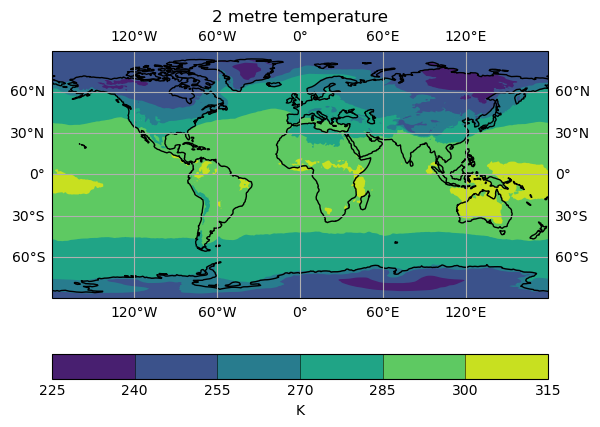

In [ ]:
# --------------------------------------
# Quickplot the first time coordinate of temp cube
# --------------------------------------

import iris.quickplot as qplt

qplt.contourf(temp_cube[0], cmap="viridis")

# add coastlines
ax = plt.gca()

ax.coastlines()

# add gridlines
ax.gridlines(draw_labels=True)

# show the plot
plt.show()

In [ ]:
# ----------------------------------------
# Pre-process the iris cube to the correct dimensions
# ----------------------------------------

import iris.coord_categorisation

# Make sure the cube only contains DJFs
temp_cube = temp_cube.extract(iris.Constraint(time=lambda t: t.point.month in [12, 1, 2]))

# AQdd the clim season diemsinsion
iris.coord_categorisation.add_season(temp_cube, "time", name="clim_season")

# Add the season year dimension
iris.coord_categorisation.add_season_year(temp_cube, "time", name="season_year")

# Now aggregate by clim season and season year to get the DJF mean
temp_cube = temp_cube.aggregated_by(["clim_season", "season_year"], iris.analysis.MEAN)

In [ ]:
temp_cube

<iris 'Cube' of 2 metre temperature / (K) (time: 65; latitude: 324; longitude: 432)>

In [ ]:
%%time
# ----------------------------------------
# Now we want to plot a time series of the arctic temperature
# Relative to the global mean temperature 
# ----------------------------------------

# Subset the cube to the arctic region (66.5 - 90N)
temp_cube_arctic = temp_cube.extract(iris.Constraint(latitude=lambda x: x > 66.5))

# Calculate the spatial mean
temp_arctic = temp_cube_arctic.collapsed(["latitude", "longitude"], iris.analysis.MEAN)

# Calculate the climatologfy
clim_arctic = temp_arctic.collapsed("time", iris.analysis.MEAN)

# Calculate the anomalies
temp_arctic_anom = temp_arctic - clim_arctic

# Extract the values
temp_arctic_anom_values = temp_arctic_anom.data

# Cclaulte the global climatology
clim_global = temp_cube.collapsed("time", iris.analysis.MEAN)

# Calculate the global anomalies
temp_global_anom = temp_cube.collapsed(["latitude", "longitude"], iris.analysis.MEAN) - clim_global.collapsed(["latitude", "longitude"], iris.analysis.MEAN)

# Extract the values
temp_global_anom_values = temp_global_anom.data

# Extract the years
years = temp_cube.coord("season_year").points

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/pytho

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2182: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'season_year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'season_year'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitud

CPU times: user 4.04 s, sys: 29.8 s, total: 33.9 s
Wall time: 31.8 s


In [ ]:
temp_global_anom_values.shape

(65,)

Text(0.5, 1.0, 'Arctic and Global DJF Mean Temperature Anomalies (1980-2020)')

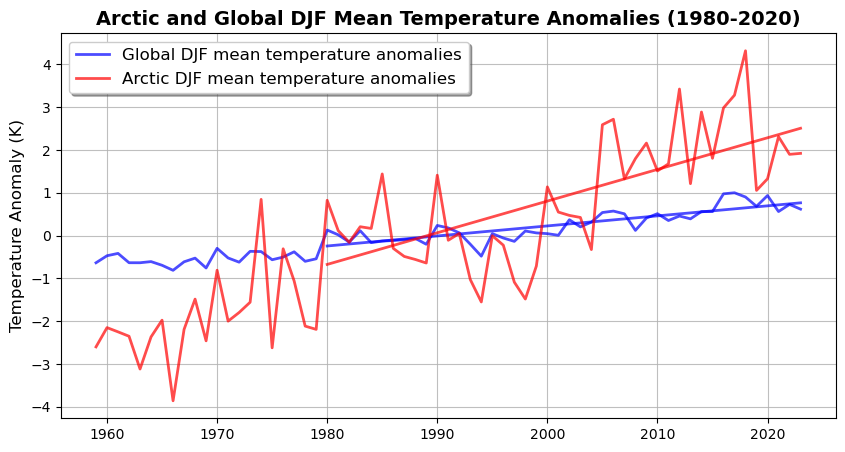

In [ ]:
# plot the time series
plt.figure(figsize=(10, 5))

# add faint gridlines
plt.grid(alpha=0.8)

# plot the global mean temperature
plt.plot(
    years,
    temp_global_anom_values,
    label="Global DJF mean temperature anomalies",
    color="blue",
    alpha=0.7,
    linewidth=2,
)

# Calculate a linear trend for the global mean temperature
slope, intercept, r_value, p_value, std_err = linregress(years[years >= 1980], temp_global_anom_values[years >= 1980])

# calculate the trend line
trend_line = slope * years + intercept

# plot the trend line
plt.plot(
    years[years >= 1980],
    trend_line[years >= 1980],
    color="blue",
    alpha=0.7,
    linewidth=2,
)

# Plot the arctic mean temperature
plt.plot(
    years,
    temp_arctic_anom_values,
    label="Arctic DJF mean temperature anomalies",
    color="red",
    alpha=0.7,
    linewidth=2,
)

# include a linear trend from the 1980s onwards
# calculate the linear trend
slope, intercept, r_value, p_value, std_err = linregress(years[years >= 1980], temp_arctic_anom_values[years >= 1980])

# calculate the trend line
trend_line = slope * years + intercept

# plot the trend line
plt.plot(
    years[years >= 1980],
    trend_line[years >= 1980],
    color="red",
    alpha=0.7,
    linewidth=2,
)

# include a legend in the top left
plt.legend(
    loc="upper left",
    fontsize=12,
    frameon=True,
    shadow=True,
    fancybox=True,
)

# set a ylabel
plt.ylabel("Temperature Anomaly (K)", fontsize=12)

# Set up the title
plt.title(
    "Arctic and Global DJF Mean Temperature Anomalies (1980-2020)",
    fontsize=14,
    fontweight="bold",
)

In [ ]:
%%time
# ------------------------------------
# Now load in the model data to plot the same thing
# ------------------------------------

# Set up the years to load
years = np.arange(1960, 2018 + 1, 1)

# Set up the directory to load from
saved_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/Amon/model/"

# Set up a array to hold the data
temp_arrs_full = np.zeros((len(years), 10, 125, 324, 432))

# loop through the years and load the data
for i, year in tqdm(enumerate(years)):
    # Set up the fname
    fname = f"HadGEM3-GC31-MM_tas_global_{year}_DJF_Amon.npy"

    # assert that the fpath exists
    assert os.path.exists(os.path.join(saved_dir, fname)), f"File {fname} does not exist"

    # load the data
    data_this_year = np.load(os.path.join(saved_dir, fname))

    # # print the shape of the data
    # print(f"Year: {year}, Shape: {data_this_year.shape}")

    # Append the data to the array
    temp_arrs_full[i, :, :, :, :] = data_this_year


0it [00:00, ?it/s]

Year: 1960, Shape: (1, 10, 125, 324, 432)


1it [00:00,  1.19it/s]

Year: 1961, Shape: (1, 10, 125, 324, 432)


2it [00:03,  2.16s/it]

Year: 1962, Shape: (1, 10, 125, 324, 432)


3it [00:10,  4.11s/it]

Year: 1963, Shape: (1, 10, 125, 324, 432)


4it [00:16,  4.97s/it]

Year: 1964, Shape: (1, 10, 125, 324, 432)


5it [00:18,  3.86s/it]

Year: 1965, Shape: (1, 10, 125, 324, 432)


6it [00:20,  3.26s/it]

Year: 1966, Shape: (1, 10, 125, 324, 432)


7it [00:22,  2.89s/it]

Year: 1967, Shape: (1, 10, 125, 324, 432)


8it [00:25,  2.89s/it]

Year: 1968, Shape: (1, 10, 125, 324, 432)


9it [00:28,  2.77s/it]

Year: 1969, Shape: (1, 10, 125, 324, 432)


10it [00:35,  4.21s/it]

Year: 1970, Shape: (1, 10, 125, 324, 432)


11it [00:37,  3.65s/it]

Year: 1971, Shape: (1, 10, 125, 324, 432)


12it [00:40,  3.23s/it]

Year: 1972, Shape: (1, 10, 125, 324, 432)


13it [00:42,  2.93s/it]

Year: 1973, Shape: (1, 10, 125, 324, 432)


14it [00:46,  3.23s/it]

Year: 1974, Shape: (1, 10, 125, 324, 432)


15it [00:48,  2.98s/it]

Year: 1975, Shape: (1, 10, 125, 324, 432)


16it [00:51,  2.75s/it]

Year: 1976, Shape: (1, 10, 125, 324, 432)


17it [00:53,  2.70s/it]

Year: 1977, Shape: (1, 10, 125, 324, 432)


18it [00:55,  2.58s/it]

Year: 1978, Shape: (1, 10, 125, 324, 432)


19it [00:58,  2.59s/it]

Year: 1979, Shape: (1, 10, 125, 324, 432)


20it [01:00,  2.45s/it]

Year: 1980, Shape: (1, 10, 125, 324, 432)


21it [01:02,  2.36s/it]

Year: 1981, Shape: (1, 10, 125, 324, 432)


22it [01:04,  2.11s/it]

Year: 1982, Shape: (1, 10, 125, 324, 432)


23it [01:06,  2.15s/it]

Year: 1983, Shape: (1, 10, 125, 324, 432)


24it [01:08,  1.96s/it]

Year: 1984, Shape: (1, 10, 125, 324, 432)


25it [01:10,  2.01s/it]

Year: 1985, Shape: (1, 10, 125, 324, 432)


26it [01:11,  1.89s/it]

Year: 1986, Shape: (1, 10, 125, 324, 432)


27it [01:15,  2.37s/it]

Year: 1987, Shape: (1, 10, 125, 324, 432)


28it [01:19,  2.82s/it]

Year: 1988, Shape: (1, 10, 125, 324, 432)


29it [01:28,  4.88s/it]

Year: 1989, Shape: (1, 10, 125, 324, 432)


30it [01:31,  4.15s/it]

Year: 1990, Shape: (1, 10, 125, 324, 432)


31it [01:40,  5.57s/it]

Year: 1991, Shape: (1, 10, 125, 324, 432)


32it [01:43,  4.77s/it]

Year: 1992, Shape: (1, 10, 125, 324, 432)


33it [01:50,  5.42s/it]

Year: 1993, Shape: (1, 10, 125, 324, 432)


34it [01:52,  4.47s/it]

Year: 1994, Shape: (1, 10, 125, 324, 432)


35it [01:56,  4.28s/it]

Year: 1995, Shape: (1, 10, 125, 324, 432)


36it [01:59,  3.96s/it]

Year: 1996, Shape: (1, 10, 125, 324, 432)


37it [02:05,  4.75s/it]

Year: 1997, Shape: (1, 10, 125, 324, 432)


38it [02:12,  5.34s/it]

Year: 1998, Shape: (1, 10, 125, 324, 432)


39it [02:15,  4.59s/it]

Year: 1999, Shape: (1, 10, 125, 324, 432)


40it [02:23,  5.73s/it]

Year: 2000, Shape: (1, 10, 125, 324, 432)


41it [02:27,  4.98s/it]

Year: 2001, Shape: (1, 10, 125, 324, 432)


42it [02:29,  4.15s/it]

Year: 2002, Shape: (1, 10, 125, 324, 432)


43it [02:35,  4.76s/it]

Year: 2003, Shape: (1, 10, 125, 324, 432)


44it [02:38,  4.23s/it]

Year: 2004, Shape: (1, 10, 125, 324, 432)


45it [02:49,  6.21s/it]

Year: 2005, Shape: (1, 10, 125, 324, 432)


46it [02:51,  4.86s/it]

Year: 2006, Shape: (1, 10, 125, 324, 432)


47it [02:52,  3.87s/it]

Year: 2007, Shape: (1, 10, 125, 324, 432)


48it [02:55,  3.50s/it]

Year: 2008, Shape: (1, 10, 125, 324, 432)


49it [02:56,  2.96s/it]

Year: 2009, Shape: (1, 10, 125, 324, 432)


50it [02:59,  2.82s/it]

Year: 2010, Shape: (1, 10, 125, 324, 432)


51it [03:01,  2.57s/it]

Year: 2011, Shape: (1, 10, 125, 324, 432)


52it [03:02,  2.23s/it]

Year: 2012, Shape: (1, 10, 125, 324, 432)


53it [03:04,  2.00s/it]

Year: 2013, Shape: (1, 10, 125, 324, 432)


54it [03:06,  1.92s/it]

Year: 2014, Shape: (1, 10, 125, 324, 432)


55it [03:10,  2.77s/it]

Year: 2015, Shape: (1, 10, 125, 324, 432)


56it [03:12,  2.42s/it]

Year: 2016, Shape: (1, 10, 125, 324, 432)


57it [03:14,  2.44s/it]

Year: 2017, Shape: (1, 10, 125, 324, 432)


58it [03:18,  2.74s/it]

Year: 2018, Shape: (1, 10, 125, 324, 432)


59it [03:24,  3.47s/it]

CPU times: user 3.8 s, sys: 2min 54s, total: 2min 58s
Wall time: 3min 24s


In [ ]:
temp_arrs_full.shape

(59, 10, 125, 324, 432)

In [ ]:
# --------------------------------------
# Subset this data to winter year means
# --------------------------------------

# Set up the winter years
winter_years = np.arange(1, 11 + 1, 1)

# Set up a new array to hold the winter means
temp_arrs_winter = np.zeros((np.shape(temp_arrs_full)[0], temp_arrs_full.shape[1], len(winter_years), temp_arrs_full.shape[3], temp_arrs_full.shape[4]))

# print the shape of temp_arrs_winter
print(f"Shape of temp_arrs_winter: {temp_arrs_winter.shape}")

# Loop over the winter years
for i, winter_year in enumerate(winter_years):
    # Set up the leads to extrcat this
    leads_this = np.arange((i * 12) + 2, (i * 12) + 2 + 3)

    # Set up the indexes of these to extract
    indexes_this = leads_this - 1

    # Subset the temp_arrs_full array to the winter years
    temp_arrs_winter_this = np.mean(temp_arrs_full[:, :, indexes_this, :, :], axis=2)

    # Append the data to the new array
    temp_arrs_winter[:, :, i, :, :] = temp_arrs_winter_this

# print the shape of temp_arrs_winter
print(f"Shape of temp_arrs_winter: {temp_arrs_winter.shape}")


Shape of temp_arrs_winter: (59, 10, 11, 324, 432)
Shape of temp_arrs_winter: (59, 10, 11, 324, 432)


In [ ]:
temp_arrs_winter[0, 0, 0, :, :]

array([[246.40551758, 246.4070638 , 246.41471354, ..., 246.4078776 ,
        246.40657552, 246.4066569 ],
       [245.91536458, 245.93066406, 245.93448893, ..., 245.88859049,
        245.90861003, 245.91162109],
       [245.54150391, 245.54174805, 245.56469727, ..., 245.51822917,
        245.51839193, 245.52799479],
       ...,
       [239.68432617, 239.69458008, 239.69962565, ..., 239.66992188,
        239.6706543 , 239.67480469],
       [239.73950195, 239.72379557, 239.72265625, ..., 239.74495443,
        239.72835286, 239.74471029],
       [239.93481445, 239.92317708, 239.92382812, ..., 239.93473307,
        239.94205729, 239.93221029]])

In [ ]:
# Import the lats and lons
model_lats_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/metadata/HadGEM3-GC31-MM_tas_global_2018_DJF_Amon_lats.npy"
model_lons_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/metadata/HadGEM3-GC31-MM_tas_global_2018_DJF_Amon_lons.npy"

# Load the lats and lons
model_lats = np.load(model_lats_path)
model_lons = np.load(model_lons_path)

In [ ]:
# Find the index of the lat closest to 66.5 degrees north
lat_index = np.abs(model_lats - 66.5).argmin()

# apply this lat index to the lats
print(model_lats[lat_index])

66.3888931274414


In [ ]:
np.shape(temp_arrs_winter)

(59, 10, 11, 324, 432)

In [ ]:
# Calculate the model climatology
# for arctic region
temp_arrs_winter_arctic = temp_arrs_winter[:, :, :, lat_index:, :]

# Calculate the spatial mean
temp_arrs_winter_arctic_mean = np.mean(temp_arrs_winter_arctic, axis=(3, 4))

# Calculate the climatology over all init years, members, and leads
temp_arrs_winter_arctic_clim = np.mean(temp_arrs_winter_arctic_mean, axis=(0, 1, 2))

# print the temp_arrs_winter_arctic_clim
print(f"values: {temp_arrs_winter_arctic_clim}")

# calculate the global climatology
temp_arrs_winter_global_mean = np.mean(temp_arrs_winter, axis=(3, 4))

# Calculate the climatology over all init years, members, and leads
temp_arrs_winter_global_clim = np.mean(temp_arrs_winter_global_mean, axis=(0, 1, 2))

# print the temp_arrs_winter_global_clim
print(f"values: {temp_arrs_winter_global_clim}")

values: 245.76986512101084
values: 276.5043653250865


In [ ]:
# Load the members
members_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/metadata/HadGEM3-GC31-MM_tas_global_2018_DJF_Amon_members.npy"

# Load the members
members = np.load(members_path)

# print the members
print(f"Members: {members}")

# strip the ints from members
members = [10, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Assuming df_full is already defined as an empty DataFrame
df_full = pd.DataFrame()

# Loop over the indices i, j, k
for i, year in enumerate(years):
    for j, member in enumerate(members):
        for k, wyear in enumerate(winter_years):
            # Set up the dataframe
            df = pd.DataFrame(
                {
                    "init_year": [year],
                    "member": [member],
                    "winter_year": [wyear],
                    "arctic_mean": [temp_arrs_winter_arctic_mean[i, j, k]],
                    "global_mean": [temp_arrs_winter_global_mean[i, j, k]],
                    "arctic_anom": [temp_arrs_winter_arctic_mean[i, j, k] - temp_arrs_winter_arctic_clim],
                    "global_anom": [temp_arrs_winter_global_mean[i, j, k] - temp_arrs_winter_global_clim],
                }
            )

            # Append to the full dataframe
            df_full = pd.concat([df_full, df], axis=0, ignore_index=True)

# Print the resulting dataframe to verify
print(df_full.head())

Members: ['r10i1p1f2' 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2' 'r5i1p1f2'
 'r6i1p1f2' 'r7i1p1f2' 'r8i1p1f2' 'r9i1p1f2']
   init_year  member  winter_year  arctic_mean  global_mean  arctic_anom  \
0       1960      10            1   244.828419   276.241672    -0.941446   
1       1960      10            2   244.879564   276.229386    -0.890302   
2       1960      10            3   246.146515   276.284285     0.376650   
3       1960      10            4   246.874682   276.223696     1.104817   
4       1960      10            5   246.726451   276.006780     0.956586   

   global_anom  
0    -0.262693  
1    -0.274980  
2    -0.220080  
3    -0.280669  
4    -0.497585  


In [ ]:
df_full.tail()

,init_year,member,winter_year,arctic_mean,global_mean,arctic_anom,global_anom,effective_dec_year
6485,2018,9,7,250.318640,277.866726,4.548774,1.362361,2024
6486,2018,9,8,251.040197,278.075250,5.270332,1.570885,2025
6487,2018,9,9,251.216307,277.940080,5.446442,1.435715,2026
6488,2018,9,10,249.255850,277.750135,3.485985,1.245770,2027
6489,2018,9,11,248.663654,277.775519,2.893789,1.271153,2028


In [ ]:
# Set up the effective dec year in the dataframe
df_full["effective_dec_year"] = df_full["init_year"] + (df_full["winter_year"] - 1)

In [ ]:
# print the unique effective dec years
unique_dec_years = df_full["effective_dec_year"].unique()

print(unique_dec_years)

[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028]


(49,)


Text(0.5, 1.0, 'DJF Mean Temperature Anomalies')

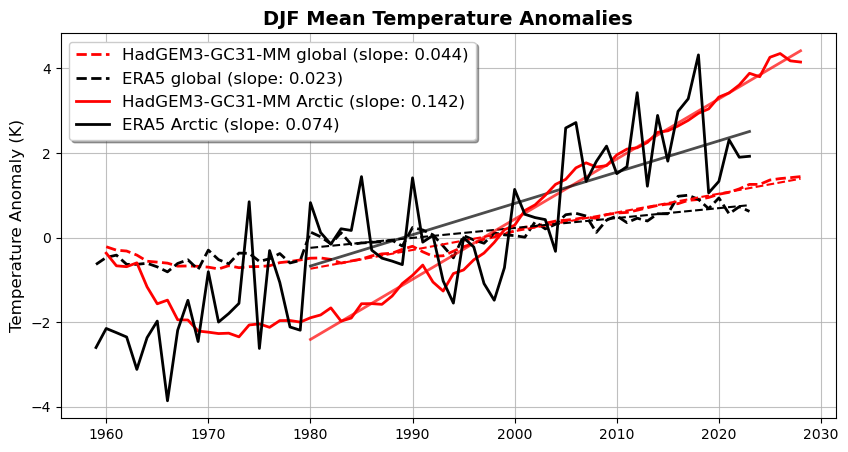

In [ ]:
# Set up the figure
fig = plt.figure(figsize=(10, 5))

# Set up faint gridlines
plt.grid(alpha=0.8)

# Set up the obs years
obs_years = temp_cube.coord("season_year").points

# Set up the filtered df
trend_df_full = df_full[df_full["effective_dec_year"] >= 1980]

# Calculate a linear trend for the global mean temperature
slope, intercept, r_value, p_value, std_err = linregress(
    trend_df_full["effective_dec_year"].unique(),
    trend_df_full.groupby("effective_dec_year")["global_anom"].mean()
)

# Calculate the trend line
trend_line = slope * trend_df_full["effective_dec_year"].unique() + intercept

# print the shape of the trend line
print(trend_line.shape)

# Calculate a linear trend for the obs global mean temperature
obs_slope, obs_intercept, obs_r_value, obs_p_value, obs_std_err = linregress(
    obs_years[obs_years >= 1980],
    temp_global_anom_values[obs_years >= 1980]
)

# Calculate the trend line
obs_trend_line = obs_slope * obs_years + obs_intercept

# Plot the global mean temperature
plt.plot(
    df_full["effective_dec_year"].unique(),
    df_full.groupby("effective_dec_year")["global_anom"].mean(),
    label=f"HadGEM3-GC31-MM global (slope: {slope:.3f})",
    color="red",
    linewidth=2,
    linestyle="--",
)

# plot the global mean temperature in the obs
plt.plot(
    obs_years,
    temp_global_anom_values,
    label=f"ERA5 global (slope: {obs_slope:.3f})",
    color="black",
    linewidth=2,
    linestyle="--",
)


# Plot the trend line
plt.plot(
    trend_df_full["effective_dec_year"].unique(),
    trend_line,
    color="red",
    linestyle="--",
)

# Plot the trend line for the obs
plt.plot(
    obs_years[obs_years >= 1980],
    obs_trend_line[obs_years >= 1980],
    color="black",
    linestyle="--",
)

# Calculate a linear trend for the arctic mean temperature
slope, intercept, r_value, p_value, std_err = linregress(
    trend_df_full["effective_dec_year"].unique(),
    trend_df_full.groupby("effective_dec_year")["arctic_anom"].mean()
)

# Calculate the trend line
trend_line = slope * trend_df_full["effective_dec_year"].unique() + intercept

# calculate the trend line for the obs
obs_slope, obs_intercept, obs_r_value, obs_p_value, obs_std_err = linregress(
    obs_years[obs_years >= 1980],
    temp_arctic_anom_values[obs_years >= 1980]
)

# Plot the trend line
plt.plot(
    trend_df_full["effective_dec_year"].unique(),
    trend_line,
    color="red",
    alpha=0.7,
    linewidth=2,
)

# Plot the trend line for the obs
plt.plot(
    obs_years[obs_years >= 1980],
    obs_slope * obs_years[obs_years >= 1980] + obs_intercept,
    color="black",
    alpha=0.7,
    linewidth=2,
)

# Plot the arctic mean temperature
plt.plot(
    df_full["effective_dec_year"].unique(),
    df_full.groupby("effective_dec_year")["arctic_anom"].mean(),
    label=f"HadGEM3-GC31-MM Arctic (slope: {slope:.3f})",
    color="red",
    linewidth=2,
)

# Plot the arctic mean temperature in the obs
plt.plot(
    obs_years,
    temp_arctic_anom_values,
    label=f"ERA5 Arctic (slope: {obs_slope:.3f})",
    color="black",
    linewidth=2,
)

# Include a legend in the top left
plt.legend(
    loc="upper left",
    fontsize=12,
    frameon=True,
    shadow=True,
    fancybox=True,
)

# Set a ylabel
plt.ylabel("Temperature Anomaly (K)", fontsize=12)

# Set up the title
plt.title(
    "DJF Mean Temperature Anomalies",
    fontsize=14,
    fontweight="bold",
)

In [ ]:
# Now calculate the trend for the UK box from clark
# to see how the trend compares
# Set up the uk clark gridbox
uk_clark = {
    "lat1": 50,
    "lat2": 60,
    "lon1": -10,
    "lon2": 3,
}

# Extract the temperature data for the UK grid box from the temp_cube
temp_cube_uk = temp_cube.extract(
    iris.Constraint(
        latitude=lambda x: (x >= uk_clark["lat1"]) & (x <= uk_clark["lat2"]),
        longitude=lambda x: (x >= uk_clark["lon1"]) & (x <= uk_clark["lon2"])
    )
)

# Print the extracted cube to verify
print(temp_cube_uk)

# find the lats and lons which correspond
uk_lat1 = np.abs(model_lats - uk_clark["lat1"]).argmin()
uk_lat2 = np.abs(model_lats - uk_clark["lat2"]).argmin()
uk_lon1 = np.abs(model_lons - uk_clark["lon1"]).argmin()
uk_lon2 = np.abs(model_lons - uk_clark["lon2"]).argmin()

# Calculate the climatology
# for UK region
temp_arrs_winter_uk = temp_arrs_winter[:, :, :, uk_lat1:uk_lat2, uk_lon1:uk_lon2]

# Calculate the spatial mean
temp_arrs_winter_uk_mean = np.mean(temp_arrs_winter_uk, axis=(3, 4))

# Calculate the climatology over all init years, members, and leads
temp_arrs_winter_uk_clim = np.mean(temp_arrs_winter_uk_mean, axis=(0, 1, 2))

# print the value of this
print(f"values: {temp_arrs_winter_uk_clim}")

# Loop over the indices i, j, k
for i, year in enumerate(years):
    for j, member in enumerate(members):
        for k, wyear in enumerate(winter_years):
            # Extract the indices for the UK region
            temp_uk_this = temp_arrs_winter_uk_mean[i, j, k]

            # add this to the dataframe
            df_full.loc[
                (df_full["init_year"] == year) &
                (df_full["member"] == member) &
                (df_full["winter_year"] == wyear),
                "uk_mean"
            ] = temp_uk_this

            # add the anoms to the df
            df_full.loc[
                (df_full["init_year"] == year) &
                (df_full["member"] == member) &
                (df_full["winter_year"] == wyear),
                "uk_anom"
            ] = temp_uk_this - temp_arrs_winter_uk_clim                                                    
# Print the resulting dataframe to verify
print(df_full.head())

2 metre temperature / (K)           (time: 65; latitude: 18; longitude: 16)
    Dimension coordinates:
        time                             x             -              -
        latitude                         -             x              -
        longitude                        -             -              x
    Auxiliary coordinates:
        clim_season                      x             -              -
        season_year                      x             -              -
    Cell methods:
        0                           clim_season: season_year: mean
values: 278.79285942655986
   init_year  member  winter_year  arctic_mean  global_mean  arctic_anom  \
0       1960      10            1   244.828419   276.241672    -0.941446   
1       1960      10            2   244.879564   276.229386    -0.890302   
2       1960      10            3   246.146515   276.284285     0.376650   
3       1960      10            4   246.874682   276.223696     1.104817   
4       1960      

In [ ]:
# process the anoms for the model
obs_uk_temp = temp_cube_uk.collapsed(["latitude", "longitude"], iris.analysis.MEAN)

# calculate the climatology
obs_uk_clim = obs_uk_temp.collapsed("time", iris.analysis.MEAN)

# calculate the anoms
obs_uk_anom = obs_uk_temp - obs_uk_clim

# Extract the values
obs_uk_anom_values = obs_uk_anom.data

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/pytho

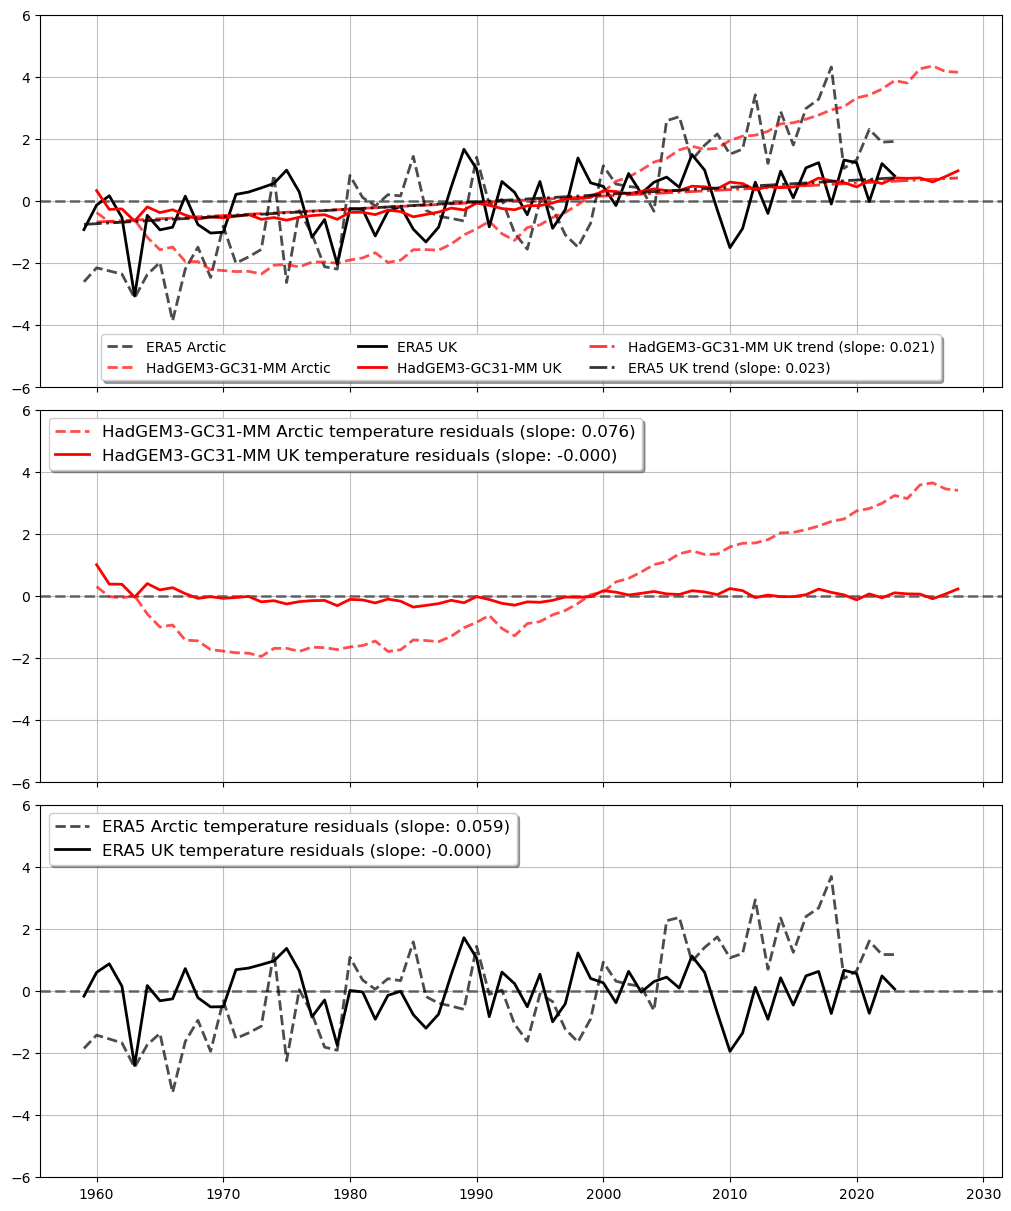

In [ ]:
# Set up a figure
# Set up a figure with subplots
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True, layout="compressed")

# Add faint gridlines to each subplot
for axis in ax:
    axis.grid(alpha=0.8)

# include a horizontal dashed line at zero
ax[0].axhline(0, color="black", linestyle="--", linewidth=2, alpha=0.5)

# Plot the obs arctic temperatures
ax[0].plot(
    obs_years,
    temp_arctic_anom_values,
    label="ERA5 Arctic",
    color="black",
    linewidth=2,
    linestyle="--",
    alpha=0.7,
)

# Plot the model arctic temperatures
ax[0].plot(
    df_full["effective_dec_year"].unique(),
    df_full.groupby("effective_dec_year")["arctic_anom"].mean(),
    label="HadGEM3-GC31-MM Arctic",
    color="red",
    linewidth=2,
    linestyle="--",
    alpha=0.7,
)

# plot the obs uk temperatures
ax[0].plot(
    obs_years,
    obs_uk_anom_values,
    label="ERA5 UK",
    color="black",
    linewidth=2,
)

# Plot the model uk temperatures
ax[0].plot(
    df_full["effective_dec_year"].unique(),
    df_full.groupby("effective_dec_year")["uk_anom"].mean(),
    label="HadGEM3-GC31-MM UK",
    color="red",
    linewidth=2,
)

# Calculate the linear trend for the model uk temperatures
model_slope, model_intercept, _, _, _ = linregress(
    df_full["effective_dec_year"].unique(),
    df_full.groupby("effective_dec_year")["uk_anom"].mean()
)

# Calculate the trend line
model_trend_line = model_slope * df_full["effective_dec_year"].unique() + model_intercept

# plot the trend line on the model data
ax[0].plot(
    df_full["effective_dec_year"].unique(),
    model_trend_line,
    color="red",
    linewidth=2,
    alpha=0.8,
    linestyle="-.",
    label="HadGEM3-GC31-MM UK trend (slope: {:.3f})".format(model_slope),
)

# Calculate the model residuals for the uk temperatures anoms
model_residuals_uk = df_full.groupby("effective_dec_year")["uk_anom"].mean() - model_trend_line

# Calculate the model residuals for the arctic temperatures anoms
model_residuals_arctic = df_full.groupby("effective_dec_year")["arctic_anom"].mean() - model_trend_line

# include one for the ax[1] plot
ax[1].axhline(0, color="black", linestyle="--", linewidth=2, alpha=0.5)

# calculate the slope for the model residuals arctic
model_slope_resid_arctic, model_intercept_resid_arctic, _, _, _ = linregress(
    df_full["effective_dec_year"].unique(),
    model_residuals_arctic
)

# calculate the slope for the model residuals uk
model_slope_resid_uk, model_intercept_resid_uk, _, _, _ = linregress(
    df_full["effective_dec_year"].unique(),
    model_residuals_uk
)

# Plot the model residuals for the arctic temperatures
ax[1].plot(
    df_full["effective_dec_year"].unique(),
    model_residuals_arctic,
    label=f"HadGEM3-GC31-MM Arctic temperature residuals (slope: {model_slope_resid_arctic:.3f})",
    color="red",
    linewidth=2,
    alpha=0.7,
    linestyle="--",
)

# Plot the model residuals for the uk temperatures
ax[1].plot(
    df_full["effective_dec_year"].unique(),
    model_residuals_uk,
    label=f"HadGEM3-GC31-MM UK temperature residuals (slope: {model_slope_resid_uk:.3f})",
    color="red",
    linewidth=2,
)

# calculate the linear trend for the uk anoms
# in the obs
obs_slope, obs_intercept, _, _, _ = linregress(
    obs_years,
    obs_uk_anom_values
)

# calculate the trend line
obs_trend_line = obs_slope * obs_years + obs_intercept

# plot the trend line on the obs data
ax[0].plot(
    obs_years,
    obs_trend_line,
    color="black",
    linewidth=2,
    alpha=0.8,
    linestyle="-.",
    label="ERA5 UK trend (slope: {:.3f})".format(obs_slope),
)

# Calculate the residuals for uk mean temperatures
obs_residuals_uk = obs_uk_anom_values - obs_trend_line

# Calculate the residuals for arctic mean temperatures
obs_residuals_arctic = temp_arctic_anom_values - obs_trend_line

# include the zero line
ax[2].axhline(0, color="black", linestyle="--", linewidth=2, alpha=0.5)

# quantify the linear slope in the residuals
obs_slope_resid_uk, obs_intercept_resid_uk, _, _, _ = linregress(
    obs_years,
    obs_residuals_uk
)

# quantify the linear slope in the arctic residuals
obs_slope_resid_arctic, obs_intercept_resid_arctic, _, _, _ = linregress(
    obs_years,
    obs_residuals_arctic
)

# Plot the residuals for the arctic temperatures
ax[2].plot(
    obs_years,
    obs_residuals_arctic,
    label=f"ERA5 Arctic temperature residuals (slope: {obs_slope_resid_arctic:.3f})",
    color="black",
    linewidth=2,
    alpha=0.7,
    linestyle="--",
)

# Plot the residuals for the uk temperatures
ax[2].plot(
    obs_years,
    obs_residuals_uk,
    label="ERA5 UK temperature residuals (slope: {:.3f})".format(obs_slope_resid_uk),
    color="black",
    linewidth=2,
)

# loop over axes and set the xlims
for axis in ax:
    axis.set_ylim(-6, 6)

    if axis == ax[0]:
        # set up the blegend with two columns in the top left
        axis.legend(
            loc="lower center",
            fontsize=10,
            frameon=True,
            shadow=True,
            fancybox=True,
            ncol=3,
        )
    else:
        # set up the legend in the top left
        axis.legend(
            loc="upper left",
            fontsize=12,
            frameon=True,
            shadow=True,
            fancybox=True,
        )